
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      2454
           1       0.94      0.91      0.92      1546

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

✅ ROC AUC Score: 0.9339052011078883
📉 Confusion Matrix:
 [[2357   97]
 [ 133 1413]]


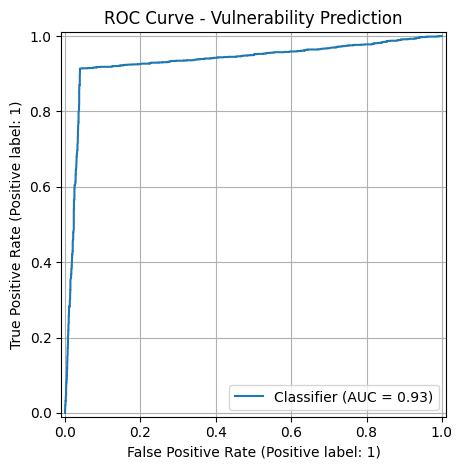

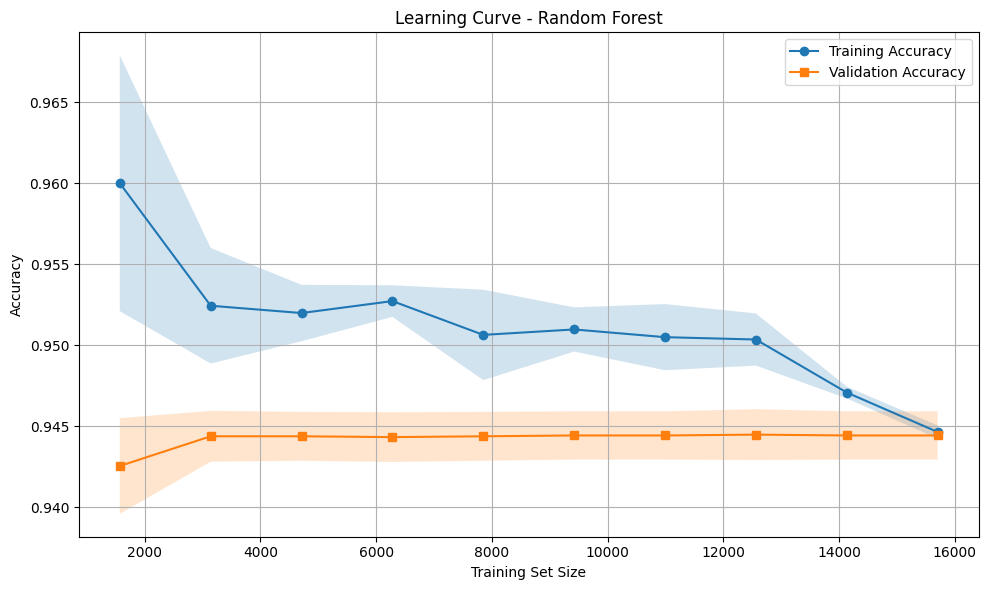

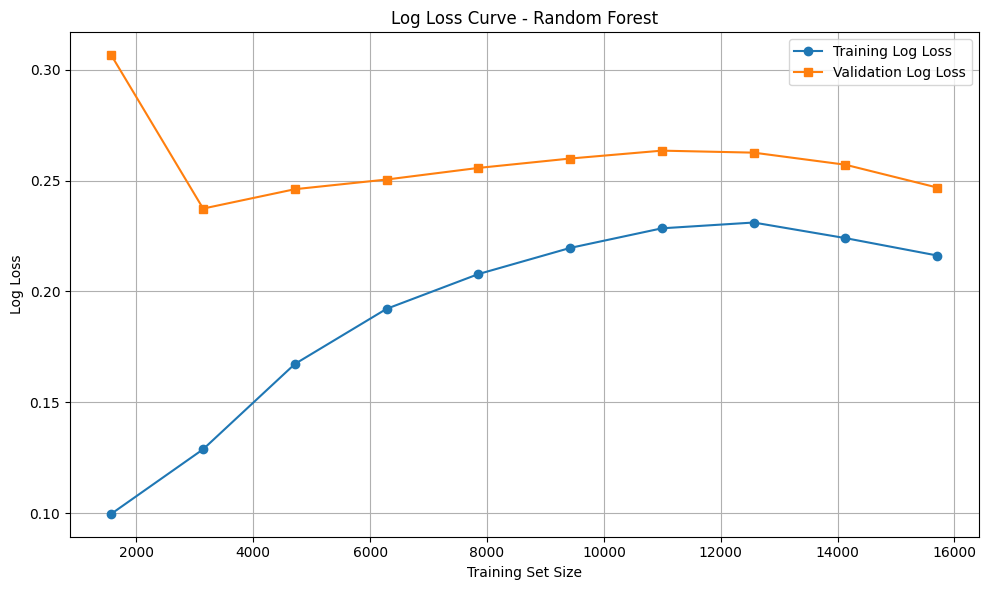

In [14]:
import re
import math
import random
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, log_loss
from scipy import sparse
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE

# 1. Load dataset
df = pd.read_csv("cryptography_dataset_enhanced.csv")
df['Key'] = df['Key'].fillna("missingkey")

# 2. Cleaning
df['ciphertext_clean'] = df['Ciphertext'].str.lower().apply(lambda x: re.sub(r'[^a-z0-9]', '', str(x)))
df['key_clean'] = df['Key'].str.lower().apply(lambda x: re.sub(r'[^a-z0-9]', '', str(x)))
df['combined_text'] = df['ciphertext_clean'] + ' ' + df['key_clean']

# 3. Entropy function
def shannon_entropy(s: str) -> float:
    if not s: return 0.0
    counts = Counter(s)
    length = len(s)
    return -sum((count / length) * math.log2(count / length) for count in counts.values())

# 4. Feature extraction
df['cipher_length'] = df['ciphertext_clean'].str.len()
df['key_length'] = df['key_clean'].str.len()
df['cipher_entropy'] = df['ciphertext_clean'].apply(shannon_entropy)
df['cipher_digit_ratio'] = df['ciphertext_clean'].apply(lambda s: sum(ch.isdigit() for ch in s) / len(s) if len(s) > 0 else 0.0)

# 5. Label generation
def generate_fuzzy_labels(row):
    weak_algorithms = ['DES', 'RC4', '3DES', 'SHA-1', 'MD5']
    score = 0
    if row['cipher_entropy'] < 3.3: score += 1
    if row['key_length'] < 8: score += 1
    if row['Algorithm'].upper() in weak_algorithms: score += 2
    if row['cipher_digit_ratio'] > 0.6: score += 1
    if random.random() < 0.05:
        return 1 if score < 2 else 0
    return 1 if score >= 2 else 0

df['vulnerability'] = df.apply(generate_fuzzy_labels, axis=1)
labels = df['vulnerability']

# 6. Feature preparation
text_corpus = df['combined_text'].values
numeric_features = df[['cipher_length', 'key_length', 'cipher_entropy', 'cipher_digit_ratio']].values
algorithms = df['Algorithm'].str.upper().values

tfidf_vectorizer = TfidfVectorizer(max_features=200)
X_text = tfidf_vectorizer.fit_transform(text_corpus)

scaler = StandardScaler()
X_numeric = scaler.fit_transform(numeric_features)

onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_alg = onehot.fit_transform(algorithms.reshape(-1, 1))

X_all = sparse.hstack([X_text, sparse.csr_matrix(X_numeric), X_alg])

# 7. Split data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X_all, labels))
X_train, X_test = X_all[train_idx], X_all[test_idx]
y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]

# 8. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train.toarray(), y_train)

# 9. Train model
model = RandomForestClassifier(
    n_estimators=80,
    max_depth=12,
    min_samples_split=4,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_res, y_train_res)

# 10. Save model and preprocessors
joblib.dump(model, "crypto_rf_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(onehot, "onehot_encoder.pkl")

# 11. Evaluation
y_scores = model.predict_proba(X_test.toarray())[:, 1]
y_pred = (y_scores >= 0.5).astype(int)

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("✅ ROC AUC Score:", roc_auc_score(y_test, y_scores))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 12. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title("ROC Curve - Vulnerability Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

# 13. Learning Curves (Accuracy)
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train_res,
    y_train_res,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Accuracy', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# 14. Loss Curves (Log Loss)
train_loss = []
val_loss = []

for size in train_sizes:
    subset_size = int(size)
    X_subset = X_train_res[:subset_size]
    y_subset = y_train_res[:subset_size]

    temp_model = RandomForestClassifier(
        n_estimators=80,
        max_depth=12,
        min_samples_split=4,
        class_weight='balanced',
        random_state=42
    )
    temp_model.fit(X_subset, y_subset)

    train_probs = temp_model.predict_proba(X_subset)
    val_probs = temp_model.predict_proba(X_test.toarray())

    train_loss.append(log_loss(y_subset, train_probs))
    val_loss.append(log_loss(y_test, val_probs))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_loss, label="Training Log Loss", marker='o')
plt.plot(train_sizes, val_loss, label="Validation Log Loss", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss")
plt.title("Log Loss Curve - Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import os
import re
import joblib
import numpy as np
from collections import Counter
from scipy import sparse

# Chargement du modèle et des outils
model = joblib.load("crypto_rf_model.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
scaler = joblib.load("scaler.pkl")
onehot = joblib.load("onehot_encoder.pkl")

VULNERABLE_ALGORITHMS = ["DES", "3DES", "RC4", "Blowfish", "SHA-1", "MD5"]

def shannon_entropy(s: str) -> float:
    if not s: return 0.0
    counts = Counter(s)
    length = len(s)
    return -sum((count/length) * np.log2(count/length) for count in counts.values())

def analyze_ciphertext(ciphertext: str, key: str, algorithm: str) -> str:
    if algorithm.upper() in [a.upper() for a in VULNERABLE_ALGORITHMS]:
        return f"{algorithm} est connu comme vulnérable - Non sécurisé !"

    cipher_clean = re.sub(r'[^a-z0-9]', '', ciphertext.lower())
    key_clean = re.sub(r'[^a-z0-9]', '', key.lower() if key else "missingkey")
    combined_text = cipher_clean + ' ' + key_clean
    entropy = shannon_entropy(cipher_clean)
    digit_ratio = sum(ch.isdigit() for ch in cipher_clean) / len(cipher_clean) if len(cipher_clean) > 0 else 0.0

    X_text = tfidf_vectorizer.transform([combined_text])
    X_num = scaler.transform([[len(cipher_clean), len(key_clean), entropy, digit_ratio]])
    X_alg = onehot.transform([[algorithm.upper()]])
    X_input = sparse.hstack([X_text, sparse.csr_matrix(X_num), X_alg])

    y_score = model.predict_proba(X_input.toarray())[0][1]
    y_pred = 1 if y_score >= 0.4 else 0

    return (
        f" Chiffrement potentiellement vulnérable ({algorithm}) - Non sécurisé !"
        if y_pred else
        f" Chiffrement sécurisé ({algorithm}) - Sécurisé."
    )

# 🔎 Test
test_cases = [
    ("3AB45CF912DEFA56C7890B12E345F678", "WeakRC4Key123", "RC4"),
    ("A1B2C3D4E5F67890", "SecureAESKey", "AES"),
    ("9fdf2bc8990abde", "", "RSA"),
]

for ciphertext, key, algo in test_cases:
    print(analyze_ciphertext(ciphertext, key, algo))

RC4 est connu comme vulnérable - Non sécurisé !
 Chiffrement sécurisé (AES) - Sécurisé.
 Chiffrement potentiellement vulnérable (RSA) - Non sécurisé !
